# プログラミング演習（機械学習演習）：教師なし学習(2)(協調フィルタリング)
## 担当：生方 誠希 ( ubukata@omu.ac.jp )
- Amazon等の電子商取引サイトやYouTubeやNetflix等の動画配信サービスに見られる[コンテンツ推薦システム](https://ja.wikipedia.org/wiki/%E3%83%AC%E3%82%B3%E3%83%A1%E3%83%B3%E3%83%80%E3%82%B7%E3%82%B9%E3%83%86%E3%83%A0)では[協調フィルタリング](https://ja.wikipedia.org/wiki/%E5%8D%94%E8%AA%BF%E3%83%95%E3%82%A3%E3%83%AB%E3%82%BF%E3%83%AA%E3%83%B3%E3%82%B0)(Collaborative Filtering, CF)(※以降，CFと表記)が活用されている．
- CFの基本的な考え方は「アイテムの嗜好パターンが類似したユーザーを見つけて，類似ユーザーが高く評価しているアイテムを推薦する」というものである．
- 今回はCFの最も基本的な手法である**相関係数法**を取り扱う．
 - ユーザー間でアイテムの嗜好パターンを比較して[相関係数](https://ja.wikipedia.org/wiki/%E7%9B%B8%E9%96%A2%E4%BF%82%E6%95%B0)を算出する．
 - 相関係数が $1$ に近いユーザーが高く評価するアイテム→推薦度向上．
 - 相関係数が $-1$ に近いユーザーが高く評価するアイテム→推薦度低下．
 - つまり，相関係数で重み付き平均をとって推薦度を決定する．
- 今回は，実データとしてCFの有名なベンチマークデータセットである「 [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/100k/) 」を用いてCFを実装する．

# 準備
- 「 [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/100k/) 」の公式サイトからデータを自動でダウンロードして使用する．
- データ分析用のライブラリ pandas の `read_table` を使用して読み込む．
- データは DataFrame という構造で保存される．
- `u.data` が全データであり，$n = 943$ ユーザーによる $m = 1682$ アイテム(映画)の評価が 100,000 件記録されている．
- 各評価は「ユーザーID, アイテム(映画)ID, レーティング(評価値), タイムスタンプ)」がタブ文字で区切られて記録されている．

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import gdown

if not os.path.isfile('u.data'):
    url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.data'
    gdown.download(url, 'u.data', quiet=False)

df = pd.read_table('u.data', names=('user_id', 'item_id', 'rating', 'timestamp'))
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


# 評価値行列の取得
各ユーザーのアイテム嗜好パターンを分析しやすくするために，データを変形しよう．
pandas の `pivot_table` を使えば，ユーザー $i$ の アイテム $k$ に対する評価値を成分 $x_{ik}$ とする user $\times$ item 行列を取得できる．
各ユーザーはすべてのアイテムの評価をしているわけではなく，評価しているのはほんの一部である．
したがって，評価がない要素には **欠損値** `NaN` (値が存在しない状態)が入る． 

In [2]:
X_df = df.pivot_table(index={'user_id'}, columns={'item_id'}, values='rating')
X_df

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ユーザー同士の相関係数を求める
相関係数法の基本的な考え方は，「嗜好パターンが類似したユーザーの嗜好は反映し，嗜好パターンが相違するユーザーの嗜好は逆の反映をする」というものである．
まずは，ユーザー同士の嗜好パターンの類似度を算出する必要がある．
類似度として，[相関係数](https://ja.wikipedia.org/wiki/%E7%9B%B8%E9%96%A2%E4%BF%82%E6%95%B0)を採用する．

- 記号説明
 - ユーザー $i$ の評価値ベクトル $\textbf{x}_{i} = (x_{i1}, ..., x_{ik}, ..., x_{im})$
 - ユーザー $j$ の評価値ベクトル $\textbf{x}_{j} = (x_{j1}, ..., x_{jk}, ..., x_{jm})$
 - ユーザー $i$ の評価値ベクトルの平均： $\overline{x}_{i}$
 - ユーザー $j$ の評価値ベクトルの平均： $\overline{x}_{j}$

- ピアソンの積率相関係数は次式で求められる．
\begin{align}
r_{ij} = \frac{\sum_{k}^{}(x_{ik}-\overline{x}_{i})(x_{jk}-\overline{x}_{j})}{\sqrt{\sum_{k}^{}(x_{ik}-\overline{x}_{i})^2}\sqrt{\sum_{k}^{}(x_{jk}-\overline{x}_{j})^2}}
\end{align}

通常，上式を計算すれば一発なのだが，今回は欠損値の `NaN` が厄介である．
`NaN` があると計算ができないため，今回の方法では各評価ベクトルを「両方のユーザーが評価しているアイテム」のみに限定して計算する．

下記コードでは，DataFrameから `values` でNumPyの行列を取り出し，一番目のユーザー `user_id=1` のベクトル `X[0]` と二番目のユーザー `user_id=2` のベクトル `X[1]` を基に相関係数を計算している(ナンバリングのズレに注意)．
リスト内包表記で，両ユーザーの評価ベクトルを走査し，いずれも欠損値でない場合のみを抽出している．
相関係数の計算は簡単にできるが，ここではNumPy の `corrcoef` 関数によって相関係数行列を求めて表示している．
当該ユーザー間の相関係数は `0.16084123` のようだ．

In [3]:
X = X_df.values
P = np.array([(a, b) for a, b in zip(X[0], X[1]) if not np.isnan(a+b)]).T
print(f'両方のユーザーが評価したアイテムに限定した評価ベクトル\n{P}')
print(np.corrcoef(P[0], P[1]))

両方のユーザーが評価したアイテムに限定した評価ベクトル
[[5. 3. 5. 5. 5. 4. 5. 5. 5. 5. 2. 5. 4. 2. 4. 5. 5. 3.]
 [4. 2. 4. 4. 3. 4. 5. 5. 4. 5. 4. 5. 5. 4. 4. 3. 4. 5.]]
[[1.         0.16084123]
 [0.16084123 1.        ]]


# ユーザー間の相関係数行列を求める
相関係数の計算方法がわかったところで，横着しよう．
pandasの `corr` 関数を使えば，先の欠損値処理を考慮して，全ユーザー間の相関係数の行列を一発で求められる．
共通して評価しているアイテムが存在しない場合，相関係数は求められず `NaN` となる．

In [4]:
X_df.T.corr()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.608412e-01,0.112780,0.500000,0.420809,0.287159,0.258137,0.692086,-0.102062,-0.092344,...,0.061695,-2.602417e-01,0.383733,2.899974e-02,0.326744,5.343904e-01,0.263289,0.205616,-0.180784,0.067549
2,0.160841,1.000000e+00,0.067420,0.148522,0.327327,0.446269,0.643675,0.585491,0.242536,0.668145,...,0.021007,-2.711631e-01,0.214017,5.616449e-01,0.331587,-7.671236e-18,-0.011682,-0.062017,0.085960,0.479702
3,0.112780,6.741999e-02,1.000000,-0.262600,NaN,-0.109109,0.064803,0.291937,NaN,0.311086,...,NaN,NaN,-0.045162,-5.233642e-17,-0.137523,NaN,-0.104678,1.000000,-0.011792,NaN
4,0.500000,1.485221e-01,-0.262600,1.000000,1.000000,-0.581318,-0.266632,0.642938,NaN,-0.301511,...,0.500000,NaN,-0.203653,NaN,0.375000,NaN,0.850992,1.000000,0.412568,NaN
5,0.420809,3.273268e-01,NaN,1.000000,1.000000,0.241817,0.175630,0.537400,0.577350,0.087343,...,0.229532,-5.000000e-01,0.439286,6.085806e-01,0.484211,8.807048e-01,0.027038,0.468521,0.318163,0.346234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.534390,-7.671236e-18,NaN,NaN,0.880705,0.206315,0.142404,-0.333333,NaN,0.316228,...,0.374351,-3.305898e-02,0.471172,-2.758386e-01,-0.073374,1.000000e+00,-0.534522,-0.131306,-0.500000,-0.187317
940,0.263289,-1.168173e-02,-0.104678,0.850992,0.027038,-0.024419,0.000931,0.320487,0.171499,0.158976,...,-0.125059,4.352858e-01,-0.338327,-1.486075e-01,0.110022,-5.345225e-01,1.000000,0.632746,-0.022813,0.332497
941,0.205616,-6.201737e-02,1.000000,1.000000,0.468521,0.399186,0.000000,0.166667,1.000000,0.420084,...,-0.500000,-2.355139e-16,0.273060,3.929526e-01,-0.214147,-1.313064e-01,0.632746,1.000000,-0.577350,-0.395285


# 推薦度の算出(※今回の課題で取り組む計算)
- 相関係数を基に，ユーザー $i$ に対するアイテム $k$ の推薦度 $y_{ik}$ を求める．
\begin{align}
y_{ik} = \overline{x}_{i} + \frac{\sum_{j}^{}r_{ij}(x_{jk}-\overline{x}_{j})}{\sum_{j}^{}|r_{ij}|}
\end{align}
- 何をしているか
 - 右辺第1項：ユーザー $i$ に対する推薦度は，ユーザー $i$ の評価ベクトルの平均値 $\overline{x}_{i}$ がベースとなる．
 - 右辺第2項：「$\sum_j$」はすべてのユーザーの情報を見ようということである．他ユーザー $j$ のアイテム $k$ の評価の**偏差**を相関係数 $r_{ij}$ で重み付き平均をとる．
 - 相関がプラスのユーザーがアイテム $k$ をプラス評価　　　→　推薦度が高くなる．
 - 相関がプラスのユーザーがアイテム $k$ をマイナス評価　　→　推薦度が低くなる．
 - 相関がマイナスのユーザーがアイテム $k$ をプラス評価　　→　推薦度が低くなる．
 - 相関がマイナスのユーザーがアイテム $k$ をマイナス評価　→　推薦度が高くなる．

# トレーニングデータとテストデータで推薦性能を評価
- 「 [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/100k/) 」の公式サイトでは，性能評価のために，トレーニングデータ `u1.base` とテストデータ `u1.test` が提供されている．
- これは，`u.data` のうち 80% をトレーニングデータ `u1.base`，20% をテストデータ `u1.test` として分割したものである．
- `u1.base` でユーザー間の類似度を測定し，推薦結果と `u1.test` の評価の整合度を評価することで推薦性能を測定する．

テストデータの各行の user_id と item_id に対し，トレーニングデータの評価値行列と相関行列に基づいて推薦度 $y$ を計算する．
その $y$ とテストデータの正解 rating の整合度が高ければ，推薦性能が良いと判断できる．

※DataFrameにおいて，user_id のインデックスは 1～943で振られているため，行列要素指定の番号 0～942 でずれたりしないように注意が必要．

---
以下のコードでは，`u1.base` と `u1.test` をダウンロードし，トレーニングデータの評価値行列 `X_train`，トレーニングデータの相関行列 `R_train`，テストデータ `test_df` を取得している．

In [5]:

if not os.path.isfile('u1.base'):
  url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u1.base'
  gdown.download(url, 'u1.base', quiet=False)
  url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u1.test'
  gdown.download(url, 'u1.test', quiet=False)

train_df = pd.read_table('u1.base', names=('user_id', 'item_id', 'rating', 'timestamp'))
X_train_df = train_df.pivot_table(index={'user_id'}, columns={'item_id'}, values='rating')
######################################################
# 修正コード：X_dfに存在し，X_train_dfに存在しない
# item_idがあれば列を追加しNaNを入れる．最後に列をソート．
######################################################
count = 0
for c in X_df.columns:
    try:
        X_train_df[c]
    except KeyError:
        count += 1
        print('c: ', c)
        X_train_df[c] = np.nan
        X_train_df = X_train_df.sort_index(axis=1)
######################################################
print('Xtr_clm', X_train_df.columns)
X_train = X_train_df.values
print('トレーニングデータの評価値行列 X_train')
print(X_train)
print('トレーニングデータの相関行列 R_train')
R_train_df = X_train_df.T.corr()
R_train = R_train_df.values
print(R_train)

test_df = pd.read_table('u1.test', names=('user_id', 'item_id', 'rating', 'timestamp'))
print('テストデータ test_df')
print(test_df)


c:  599
c:  711
c:  814
c:  830
c:  852
c:  857
c:  1156
c:  1236
c:  1309
c:  1310
c:  1320
c:  1343
c:  1348
c:  1364
c:  1373
c:  1457
c:  1458
c:  1492
c:  1493
c:  1498
c:  1505
c:  1520
c:  1533
c:  1536
c:  1543
c:  1557
c:  1561
c:  1562
c:  1563
c:  1565
c:  1582
c:  1586
Xtr_clm Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682],
           dtype='int64', name='item_id', length=1682)
トレーニングデータの評価値行列 X_train
[[ 5.  3.  4. ... nan nan nan]
 [ 4. nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [ 5. nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan  5. nan ... nan nan nan]]
トレーニングデータの相関行列 R_train
[[ 1.          0.26967994  0.5        ...  0.67936622 -0.19348921
   0.24303845]
 [ 0.26967994  1.                 nan ...  0.          0.25943726
   0.62749502]
 [ 0.5                nan  1.         ...  1.          0.64888568
          nan]
 ...
 [ 0.67

# テストデータに対する推薦および推薦性能の評価
## 推薦性能の評価指標
CFの推薦性能の評価指標として，[ROC-AUC指標](https://ja.wikipedia.org/wiki/%E5%8F%97%E4%BF%A1%E8%80%85%E6%93%8D%E4%BD%9C%E7%89%B9%E6%80%A7#%E6%A6%82%E8%A6%81)がある．
推薦度に対する推薦の閾値を種々変化させた場合の偽陽性率(False Positive Rate, FPR)に対する真陽性率(True Positive Rate, TPR)のプロットをROC曲線という．
ROC曲線の下部の面積がROC-AUCであり，AUCが大きい($1$ に近い)ほど推薦性能が高いといえる．
ランダムに推薦を行った場合，AUCは $0.5$ 程度になる．

---
以下のコードでは，テストデータの各行について，ユーザー $i$ に対するアイテム $k$ の推薦度を計算する準備を行っている．
現在，推薦度を `y = np.random.rand()*4 + 1` のように 1～5 の乱数で決定している．
つまり，まともに推薦できていない状態である．
ここで，`y` を相関行列を基に適切に計算したものに置き換えることが本演習の目的となる．

- 計算に必要な行列
 - 評価値行列 `X_train`
 - 相関行列 `R_train`
 - 評価値の偏差の行列 `D_train`
- 欠損値が含まれるため，必要に応じて `np.nanmean` や `np.nansum` を用いる．
---
テストデータの各行の推薦度を算出後，`sklearn.metrics` の `roc_curve`, `roc_auc_score` を利用してROC曲線とAUCの値を示している．
テストデータの正解 rating は 1～5 の整数をとるが，AUC算出の際は「推薦するべきかしないべきか」の {0, 1} の2値にする必要があるため，`result[:, 0] >= 2` のように「rating が2以上なら推薦」というようにしている．
現在はランダムな推薦のため，$AUC = 0.5$ 程度になっていることが確認できる．
本演習のタスクは，以下のランダムな推薦を前述の相関係数法による推薦に置き換え，ROC曲線とAUC値を観察することである．

In [6]:
X_train.shape #(len_user, len_item)

(943, 1682)

In [12]:
R_train[user_idx, :].shape, D_train[:, item_idx].shape

((943,), (943,))

「真の評価値」と「推定した評価値」
[[5.         3.67364767]
 [3.         3.68789029]
 [5.         3.81837882]
 ...
 [3.         3.36029979]
 [3.         3.44247841]
 [5.         3.95661321]]
ROC-AUCスコア：0.7498732186628154


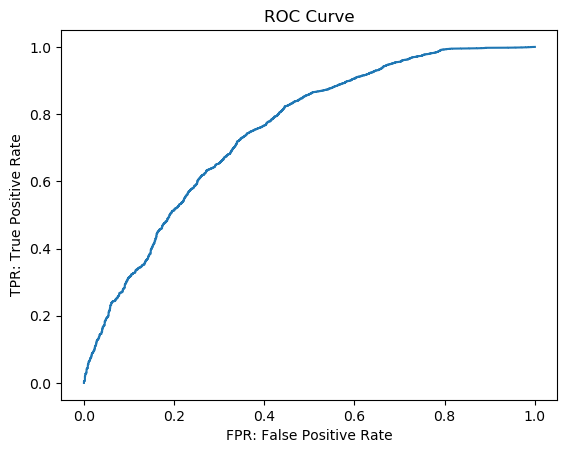

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

# 評価値の偏差の行列を算出しておく．
D_train = X_train - np.nanmean(X_train, axis=1)[:, np.newaxis]

result = []
for i, k, rate, time in test_df.values:
  ###########################
  # 以下でユーザー i に対するアイテム k の推薦度 y を計算する．
  # 現在，仮に推薦度 y は 1～5 間の乱数で適当に決定されている．
  # この y を適切にコーディングする．
  # ※DataFrameにおいて，user_id のインデックスは 1～943で振られているため，
  #   行列要素指定の番号 0～942 でずれたりしないように注意が必要．
  ## Start ##################
#   y = np.random.rand()*4 + 1
    user_idx = i -1
    item_idx = k -1
    
    mean_xi =np.nanmean(X_train[user_idx, :])
    top = np.nansum(R_train[user_idx, :] * D_train[:, item_idx])
    bottom = np.nansum(np.abs(R_train[user_idx, :]))
    y =  mean_xi + top / bottom
#     y =  mean_xi
  ## End ####################
  
  # 「真の評価値」と「推定した評価値」を保存する．
    result.append([rate, y])

print('「真の評価値」と「推定した評価値」')
result = np.array(result)
print(result)

fpr, tpr, thresholds = roc_curve(result[:, 0] >= 2, result[:, 1])
# plt.plot(fpr, tpr, marker='o')
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR: False Positive Rate')
plt.ylabel('TPR: True Positive Rate')
print(f'ROC-AUCスコア：{roc_auc_score(result[:, 0] >= 2, result[:, 1])}')
plt.show()

# 課題
## 実行環境
Google Colaboratory を推奨．
## 要件
- 最後に示したコードを改変し，テストデータ `u1.test` の各評価について，`u1.base` の評価値行列と相関行列を基に推薦度を算出するようにせよ．
- ROC曲線とAUC値を示すこと．

※注意：for文を使用せずに数式はNumPyを活用して実装すること．
***
## 提出について
- 下記の要件を満たす1つのWordファイルを提出する．
 - ファイル名「report8_XXXXX.docx」．ここで，XXXXXは各自の学籍番号．
 - 講義名，講義回，学籍番号，氏名，提出日を明示する．
 - 取り組んだ内容，ソースコード，コードの自作部分の解説，実行結果(グラフ)，結果の考察を記述する．
- 授業支援システムより提出．提出期限は授業支援システムを参照．

In [15]:
np.nansum(np.dot(R_train[user_idx, :] ,  D_train[:, item_idx]))

0.0

In [13]:
R_train[user_idx, :] * D_train[:, item_idx]

array([            nan,             nan,             nan,             nan,
                   nan,             nan, -7.72413432e-01,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  

In [17]:
np.nansum(R_train[i-1] @ D_train)

0.0

In [ ]:
np.nansum(np.dot(R_train[user_idx, :],  D_train[:, item_idx]))